### Regresion Predict Fuel Efficiency

In [47]:
#seaborn for pairplot 
!pip install seaborn

In [48]:
from __future__ import absolute_import,division,print_function
import pathlib
import pandas as pd
import seaborn as sns

import tensorflow as tf 
from  tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.3.0


#### Download the data

In [49]:
dataset_path = keras.utils.get_file("auto-mpg.data","https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/root/.keras/datasets/auto-mpg.data'

Import it using pandas

In [50]:
column_names =['MPG','Cylinders','Displacement','Horsepower' ,'Weight','Acceleration','Model Year','Origin']

raw_dataset =pd.read_csv(dataset_path,names=column_names,na_values="?",comment='\t',sep=" ",skipinitialspace=True)

dataset = raw_dataset.copy()
print(dataset.shape)
dataset.head()

(398, 8)


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


#### Cleaning data

In [51]:
## dataset contains few unknown values

dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [52]:
## dropping those unknow values 

dataset =dataset.dropna()
print(dataset.shape)
dataset.isna().sum()

(392, 8)


MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

Origin column is really categorical not numeric .So convert that to one-hot.

In [53]:
origin = dataset.pop('Origin') ## removes origin column
origin

0      1
1      1
2      1
3      1
4      1
      ..
393    1
394    2
395    1
396    1
397    1
Name: Origin, Length: 392, dtype: int64

In [54]:
dataset['USA'] = (origin==1)*1.0
dataset['Europe'] = (origin==2)*1.0
dataset['Japan'] = (origin==3)*1.0

dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
0,18.0,8,307.0,130.0,3504.0,12.0,70,1.0,0.0,0.0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1.0,0.0,0.0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1.0,0.0,0.0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1.0,0.0,0.0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1.0,0.0,0.0


In [46]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [55]:
dataset.dtypes

MPG             float64
Cylinders         int64
Displacement    float64
Horsepower      float64
Weight          float64
Acceleration    float64
Model Year        int64
USA             float64
Europe          float64
Japan           float64
dtype: object

#### Split the data into train and test

In [56]:
train_dataset  = dataset.sample(frac =0.8 ,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
print('Shape of train set is: {}'.format(train_dataset.shape))
print('Shape of test set is: {}'.format(test_dataset.shape))

Shape of train set is: (314, 10)
Shape of test set is: (78, 10)


#### Inspect the data 
Look at the joint distribution of a few pairs of columns from training

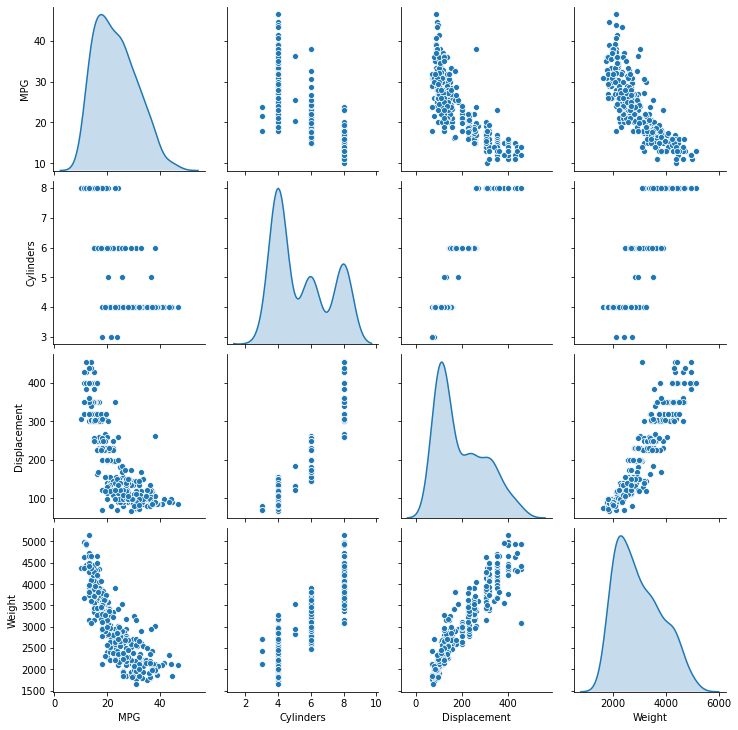

In [57]:
sns.pairplot(train_dataset[['MPG','Cylinders','Displacement','Weight']],diag_kind="kde")

Also look at overall statistics

In [58]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


#### Split features from labels

Seperate target values/labels from the features.This label is the value that we train the Model to predict.

In [59]:
train_labels = train_dataset.pop('MPG')
test_labesl = test_dataset.pop('MPG')

#### Normalize the data

From the train_stats feature we find the range of values are so different for each feature.
Hence,it is good to normalize features that uses different scales and ranges.Altough the model might converge without normalization ,it makes training more difficult,and makes the model depenendent on the choice of units used in the input.

Note: Need to normalize for test set also.

In [60]:
def norm(x):
  return (x-train_stats['mean'])/train_stats['std']

normalized_train_data = norm(train_dataset)
normalized_test_data = norm(test_dataset)

print(normalized_train_data.shape)
print(normalized_test_data.shape)

(314, 9)
(78, 9)


This normalized data will be used to train the model.

Caution: The statistics used to normalize the inputs here(mean & std dev) need to be applied to any other data that is fed to the model,along with one-hot encoding that was done earlier.That includes the test set as well as the live data when the model is used in production.


#### The Model

**Build the Model**

Here we use sequential model with 2 densely connected hidden layers,and an output layer that returns a single,continous value.

In [61]:
def build_model():
  model = keras.Sequential([
             layers.Dense(units=64,activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]) , 
             layers.Dense(units=64,activation=tf.nn.relu),
             layers.Dense(units=1)  #linear activation  as it is regression model            
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae','mse'])
  return model

In [62]:
model = build_model()

#### Inspect the Model

Use .summary method to print a simple description of the model

In [63]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


Now try out the model.Take a batch of 10 examples from the training data and call model.predict on it.

In [64]:
example_batch = normalized_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.10394785],
       [ 0.01218427],
       [-0.266499  ],
       [ 0.12214999],
       [ 0.28927678],
       [ 0.13891631],
       [ 0.32584673],
       [ 0.4480387 ],
       [ 0.05454835],
       [ 0.26537555]], dtype=float32)

#### Train the Model

Train the model for 1000 epochs ,and record the training and validation accuracy in the history object.

In [65]:
## Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs):
    if epoch %100 ==0:
      print('')
    print('.',end='')

EPOCHS =1000

history = model.fit(
    normalized_train_data,train_labels,epochs =EPOCHS,
    validation_split=0.2,verbose=0,
    callbacks=[PrintDot()]
)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

Visualize the model's training progress using stats stored in the history object.

In [66]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.658983,0.997999,2.658983,10.634463,2.455093,10.634463,995
996,2.651183,1.008214,2.651183,11.197553,2.522622,11.197553,996
997,2.749323,1.074863,2.749323,10.305855,2.447983,10.305855,997
998,2.708001,1.046977,2.708001,10.284341,2.379956,10.284341,998
999,2.749020,1.012028,2.749020,10.350454,2.393812,10.350454,999


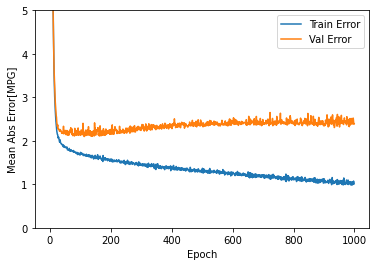

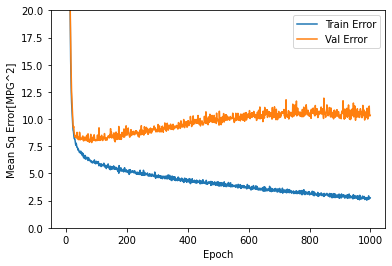

In [67]:
import matplotlib.pyplot as plt 

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error[MPG]')
  plt.plot(hist['epoch'] , hist['mae'],label='Train Error')
  plt.plot(hist['epoch'] , hist['val_mae'],label='Val Error')
  plt.legend()
  plt.ylim([0,5])

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Sq Error[MPG^2]')
  plt.plot(hist['epoch'] , hist['mse'],label='Train Error')
  plt.plot(hist['epoch'] , hist['val_mse'],label='Val Error')
  plt.legend()
  plt.ylim([0,20])

plot_history(history)


Validation error is going up this is a classical case of overfitting.

This graph shows little improvement or even degredation of validation error after about 1000 epochs. Lets update model.fit call to automatically stop training when validation score doesn't improve. 

We'll use an EarlyStopping callback that test a training condition for every epoch. If a set amount of epochs elapses without showing improvement,then automatically stop the training.


................................................................................................

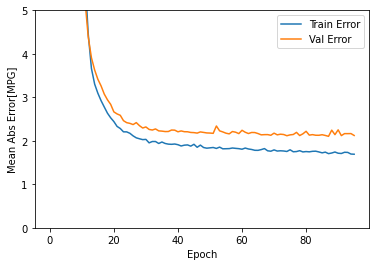

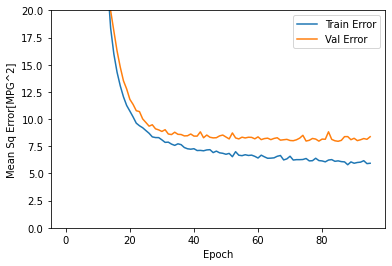

In [69]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)

history = model.fit(normalized_train_data, train_labels ,epochs=EPOCHS ,
                    validation_split=0.2 ,verbose=0,callbacks=[early_stop, PrintDot()])

plot_history(history)

The graph shows that on the validation set, the average error is usually around +/- 2 MPG. Is this good? We'll leave that decision up to you.

Let's see how well the model generalizes by using the test set, which we did not use when training the model. This tells us how well we can expect the model to predict when we use it in the real world.

In [70]:
loss, mae, mse = model.evaluate(normalized_test_data, test_labesl, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 6.1330 - mae: 1.9839 - mse: 6.1330
Testing set Mean Abs Error:  1.98 MPG


#### Make Prediction

Finally, predict MPG values using data in the testing set:

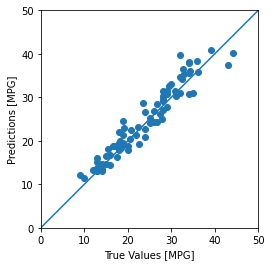

In [71]:
test_predictions = model.predict(normalized_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labesl, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


It looks like our model predicts reasonably well. Let's take a look at the error distribution.

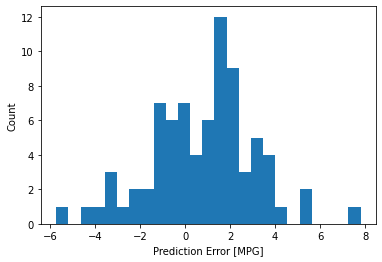

In [72]:
error = test_predictions - test_labesl
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

It shows pretty close to gaussian.

**Conclusion**

- Mean Squared Error (MSE) is a common loss function used for regression problems (different loss functions are used for classification problems).
- Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
- When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
- If there is not much training data, one technique is to prefer a small network with few hidden layers to avoid overfitting.
Early stopping is a useful technique to prevent overfitting.
